<a href="https://colab.research.google.com/github/teruyo14/Classification-of-CIFAR10-with-Major-CNNs-and-Visualization-with-t-SNE/blob/main/Classification_of_CIFAR10_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Papers: Deep Residual Learning for Image Recognition  
https://arxiv.org/pdf/1512.03385.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import copy
import torch.nn.functional as F

In [2]:
device = "cuda"

In [3]:
device

'cuda'

In [4]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 60953620.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, return_embed=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        if return_embed:
            return out
        return out

    def get_device(self):
        return self.linear.weight.device

    def copy(self):
        return copy.deepcopy(self)


In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

"""
ResNet18
[2, 2, 2, 2]


ResNet34
[3, 4, 6, 3]


ResNet50
[3, 4, 6, 3]


ResNet101
[3, 4, 23, 3]


ResNet152
[3, 8, 36, 3]
"""

In [8]:
model = ResNet18()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=5e-4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
def plot_t_sne(data_loader, model,num_samples):
    model.eval()

    # Formatting data for t-SNE
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # Extracting features
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # To Numpy Array
    x = x.numpy()
    y = y.numpy()

    # Extract a specified number of samples
    x = x[:num_samples]
    y = y[:num_samples]

    # Apply t-SNE
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # Set color and marker for each label
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # Plot data
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')

    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.title("Model:ResNet18", fontsize = 70, y = -0.1)
    plt.show()

epoch: 1, loss: 1.2723564783579557, acc: 0.5388475656509399,      val loss: 0.9747968137073821, val acc: 0.6463658213615417
epoch: 2, loss: 0.8564695053884637, acc: 0.6995561718940735,      val loss: 0.7444826730143148, val acc: 0.733526349067688
epoch: 3, loss: 0.6871481240081696, acc: 0.7614763379096985,      val loss: 0.6232013370567998, val acc: 0.7780550718307495
epoch: 4, loss: 0.5916547579827861, acc: 0.794745683670044,      val loss: 0.5621374216609107, val acc: 0.8041133880615234
epoch: 5, loss: 0.5216977691047862, acc: 0.8196976780891418,      val loss: 0.5190995565047279, val acc: 0.8194888234138489
epoch: 6, loss: 0.47509285421971703, acc: 0.8371521234512329,      val loss: 0.49505170494222794, val acc: 0.831569492816925
epoch: 7, loss: 0.43168114772112953, acc: 0.8516075015068054,      val loss: 0.4882817039855372, val acc: 0.8287739753723145
epoch: 8, loss: 0.39522336117365536, acc: 0.8662227988243103,      val loss: 0.44363265839247656, val acc: 0.84375
epoch: 9, loss: 0

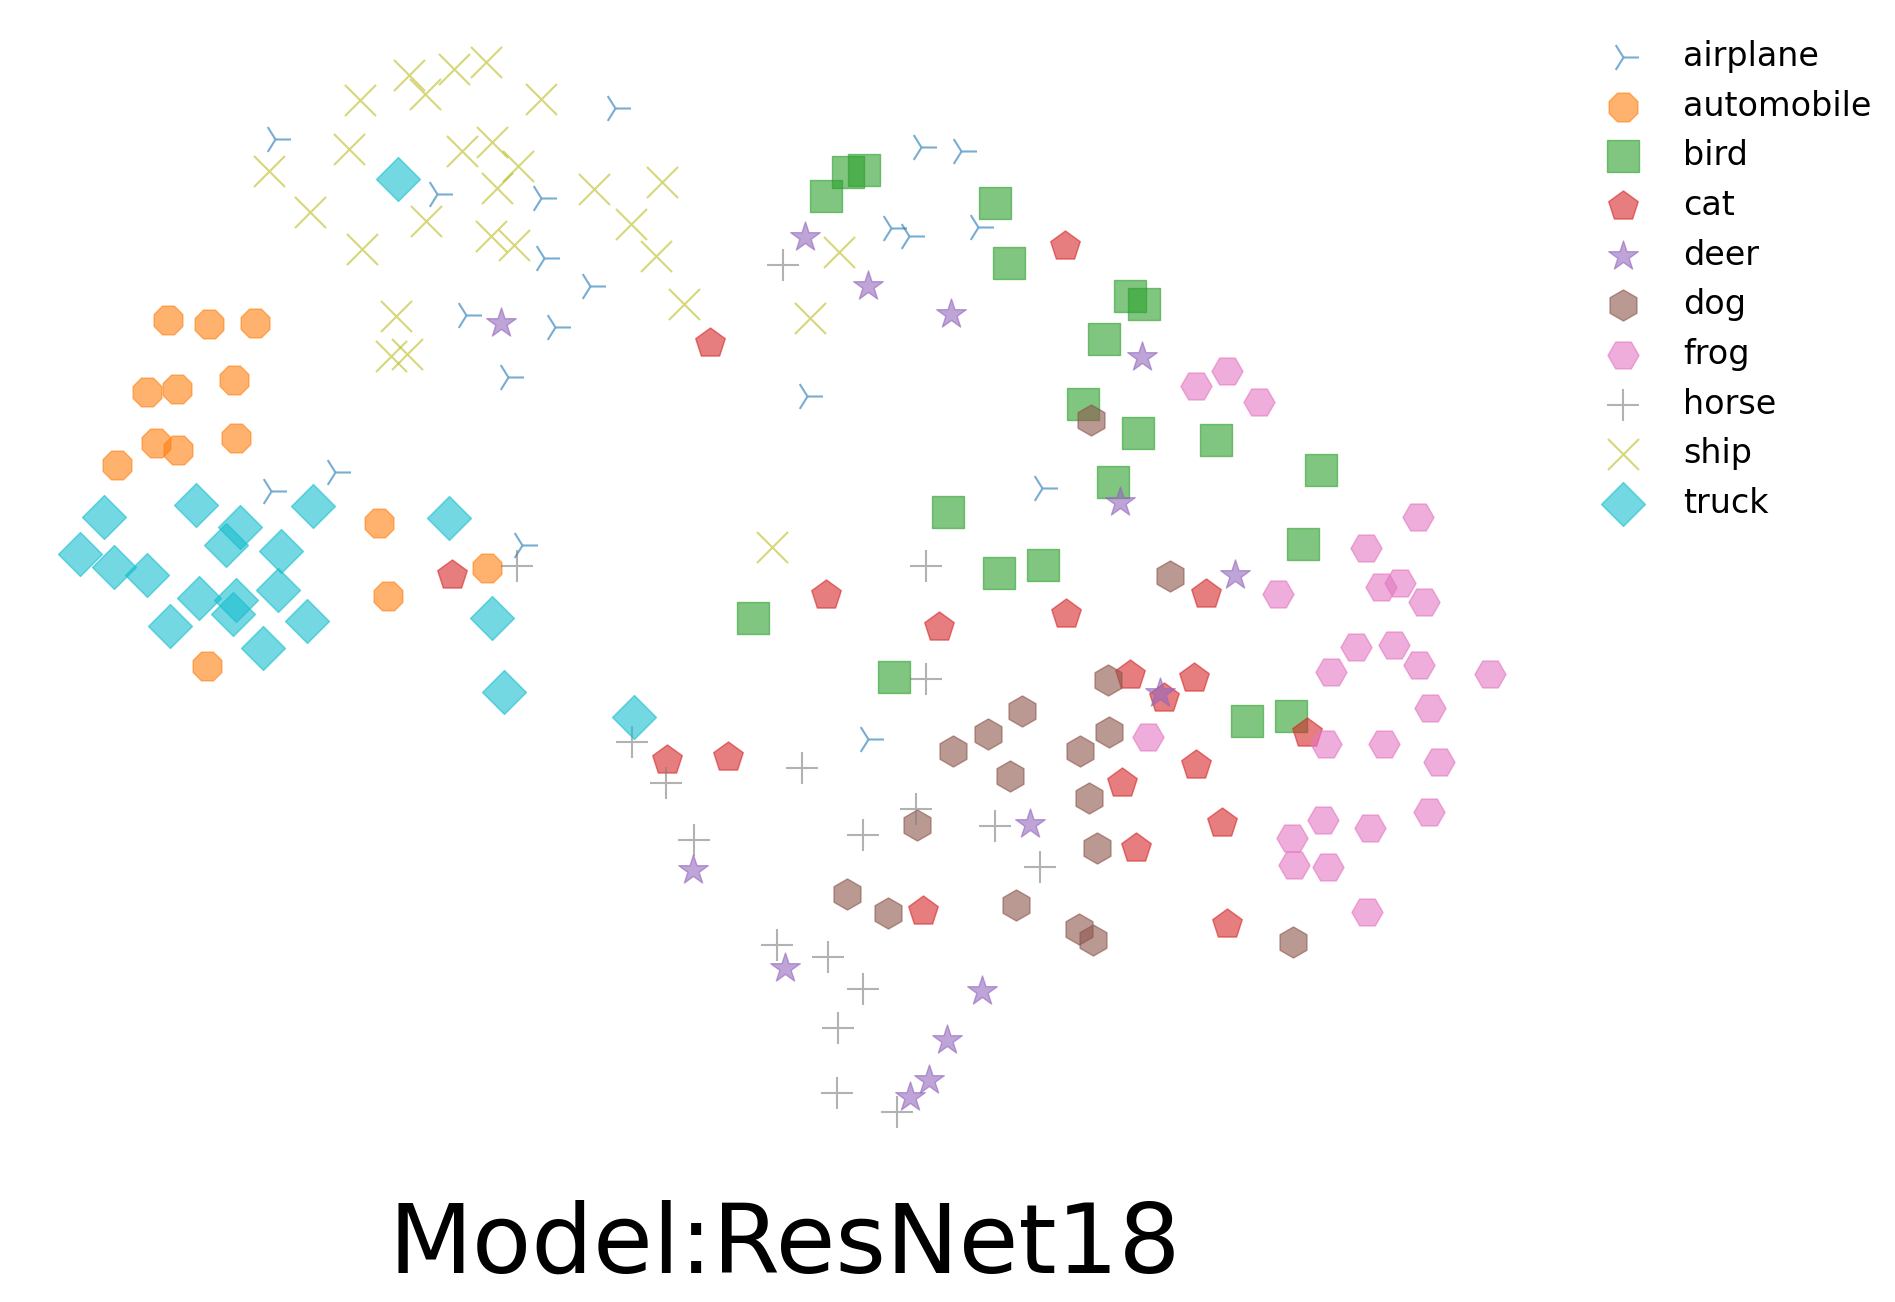

In [11]:
num_epochs = 20
num_samples = 200
losses = []
accs = []
val_losses = []
val_accs = []
val_acc_best = 0.0
model_best = None
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.item())
    #
    # validation loop
    #
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.item())
    if val_running_acc > val_acc_best:
            val_acc_best = val_loss
            model_best = model.copy()
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))

# Plot distribution of features using t-SNE
plot_t_sne(validation_dataloader, model_best, num_samples)

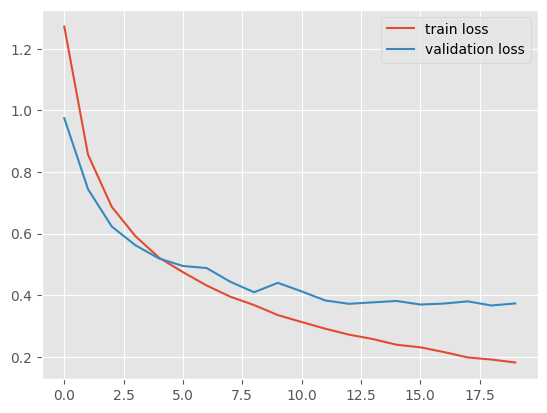

In [12]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

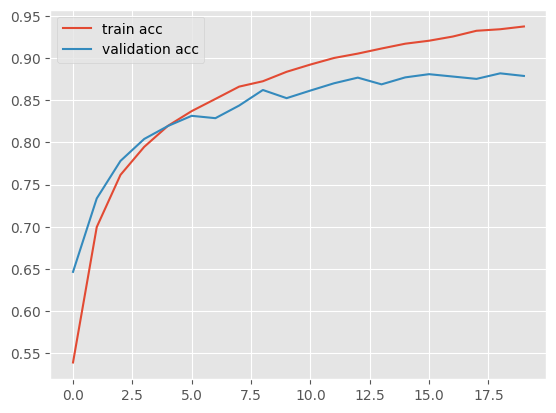

In [13]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()